### Preprocessing:
    Création du Train set/Test set
    Elimination des NaN
    Encodage 
    Suppression des outliers néfastes aux modèles
    Features Selection 
    Feature Engineering 
    Feature Scaling 


In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns


In [4]:
dfb=pd.read_excel('dataset.xlsx')
df=dfb.copy()
#Elimination des variables avec plus de 90% de Nan
df=df[df.columns[df.isna().sum()/df.shape[0]<0.9]]
#Elimination des variable  test rapide (jugés moins fiable lors de l'exploration des données)
df=df.drop(['Influenza A, rapid test','Influenza B, rapid test'], axis =1)
#Elimination de la variable patient ID
df=df.drop(['Patient ID'], axis =1)
#Elimination des variables ayant une seule catégories
for col in df.select_dtypes('object').columns:
    df1=df[col].dropna()
    #print(f'{col:-<50} {df1.unique()}')
    #print(len(df1.unique()))
    if len(df1.unique())<2:
        print(f' Variables à supprimer : {col}')
        df=df.drop([col],axis=1)
#Elimination des Nan pour toutes les variable categorielle
df=df.dropna(subset=df.select_dtypes('float').columns)


 Variables à supprimer : Parainfluenza 2


In [5]:
#création colonne des affectation des soins ald des 3 colonnes soins
def hospitalisation(df) :
    if df['Patient addmited to semi-intensive unit (1=yes, 0=no)']==1:
        return'semi_intensive'   
    if df['Patient addmited to intensive care unit (1=yes, 0=no)']==1:
        return'intensive'
    if df['Patient addmited to regular ward (1=yes, 0=no)']==1:
        return'regular_ward'
    else :
        return 'not_admitted'
df['statut']=df.apply(hospitalisation, axis=1)
df=df.drop(['Patient addmited to regular ward (1=yes, 0=no)','Patient addmited to semi-intensive unit (1=yes, 0=no)','Patient addmited to intensive care unit (1=yes, 0=no)'],axis=1)

(598, 33)

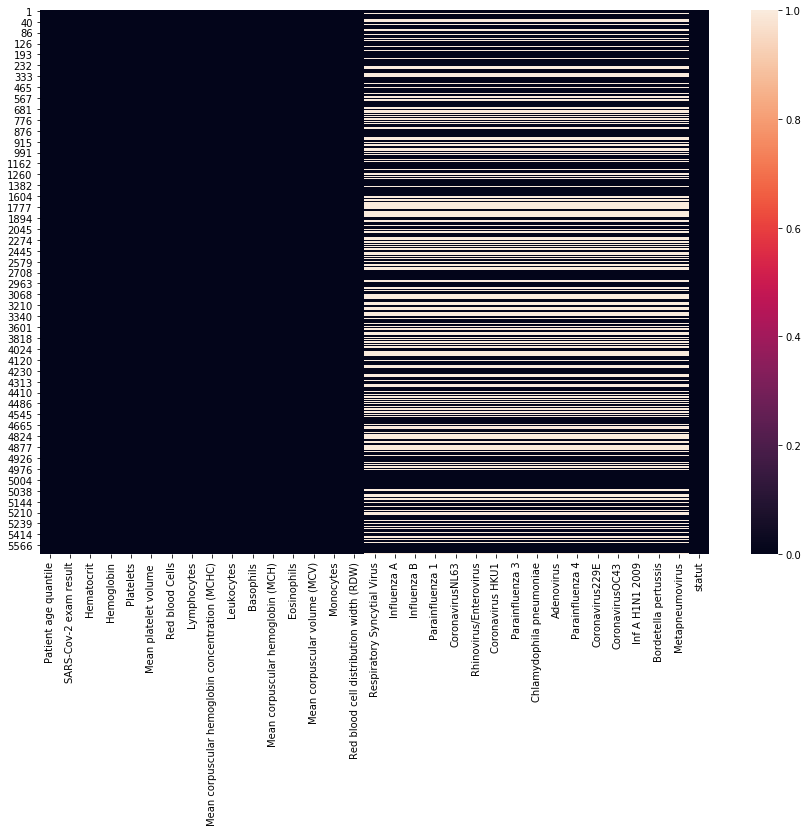

In [6]:
plt.figure(figsize=(15,10))
#sns.heatmap(df.isna())
df.shape
#df=df.dropna()
sns.heatmap(df.isna())
df.shape

In [7]:
#selection des variables et de la target
y=df['SARS-Cov-2 exam result']
X=df.drop(['SARS-Cov-2 exam result'], axis=1)


In [8]:
#Création du Train set/Test set 

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.2, random_state=0)
X_train.shape

(478, 32)

In [9]:
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
#Common Model Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score


#for i in [SGDClassifier(random_state=0),KNeighborsClassifier(5)]:
numerical_Features = make_column_selector(dtype_include=np.number)
categorical_Features = make_column_selector(dtype_exclude=np.number)

numerical_pipeline = make_pipeline(SimpleImputer(),StandardScaler())
categorical_pipeline= make_pipeline(SimpleImputer(strategy='most_frequent'),OneHotEncoder(handle_unknown='ignore'))
transformer=make_column_transformer((numerical_pipeline, numerical_Features), (categorical_pipeline,categorical_Features))
random_state=0
classifiers = [
              LogisticRegression(random_state = random_state),
              LinearDiscriminantAnalysis(),
              KNeighborsClassifier(),
              SVC(random_state=random_state),
              DecisionTreeClassifier(random_state=random_state),
              RandomForestClassifier(random_state=random_state),
              AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1),
              GradientBoostingClassifier(random_state=random_state),
              MLPClassifier(random_state=random_state),
              SGDClassifier(random_state = random_state)
              ]
encoderY =LabelEncoder()
Xtransformed=transformer.fit_transform(X_train)
#ytransformed=transformer.fit_transform(y_train)
y_transformed=encoderY.fit_transform(y_train)

Xtesttransformed=transformer.transform(X_test)
ytesttransformed=encoderY.transform(y_test)

res_columns=['clf name', 'clf accuracy Mean', 'clf recall','clf precision','clf f1score','clfrecalltest']
df_result = pd.DataFrame(columns = res_columns)
cv=StratifiedKFold(5)
idx_raws=0
for cl in classifiers: 
    cl.fit(Xtransformed,y_transformed)
    df_result.loc[idx_raws, 'clf name']= cl.__class__.__name__
    df_result.loc[idx_raws,'clf accuracy Mean' ]=cross_val_score(cl,Xtransformed, y_transformed, scoring='accuracy', cv=cv).mean()
    df_result.loc[idx_raws,'clf recall' ]=cross_val_score(cl,Xtransformed, y_transformed, scoring='recall', cv=cv).mean()
    df_result.loc[idx_raws,'clf precision' ]=cross_val_score(cl,Xtransformed, y_transformed, scoring='precision', cv=cv).mean()
    df_result.loc[idx_raws,'clf f1score' ]=cross_val_score(cl,Xtransformed, y_transformed, scoring='f1', cv=cv).mean()
    df_result.loc[idx_raws,'clfrecalltest' ]=recall_score(ytesttransformed,cl.predict(Xtesttransformed))
    
    idx_raws=idx_raws+1

df_result.sort_values(by='clfrecalltest',ascending=False,inplace=True)
df_result


#for cl in classifiers: 
 #   cl.fit(Xtransformed,y_transformed)
    #print(cl.score(Xtesttransformed,ytesttransformed))
  #  print (f'le score du model{cl.__class__.__name__ :.<30} est  : {cl.score(Xtesttransformed,ytesttransformed)}')
    #print({cl.__class__.__name__})
    #print(classification_report(y_test,model.predict(X_test)))
#model=make_pipeline(transformer,SGDClassifier())
#={'kneighborsclassifier__n_neighbors': np.arange(1,20),
 #      'kneighborsclassifier__metric': ['euclidean','manhattan']}
#param={'sgdclassifier__penalty': ['l1','l2']}
#Grid=GridSearchCV(model, param_grid=param,cv=StratifiedKFold(10,shuffle=True))
#model.fit(X_train,y_train)
#Grid.fit(X_train,y_train)
#print (Grid.best_params_)
#print (Grid.best_score_)
#model_fin=Grid.best_estimator_
#print(f'le train score pour estimateur est : {model.score(X_train,y_train_transformed)}')
#print(f'le test score pour estimateur  est :{model.score(X_test,y_test_transformed)}')

#Evaluation du model 
#print(classification_report(y_test,model_fin.predict(X_test)))
#sns.heatmap(confusion_matrix(y_test,model_fin.predict(X_test)),annot=True,fmt='d',cbar=False)

NameError: name 'recall_score' is not defined

In [21]:
#OneHotEncoder(handle_unknown='ignore').fit_transform(y_train.values.reshape(y_train.shape[0],1))
type(X_train.values)


numpy.ndarray

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimi

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimi

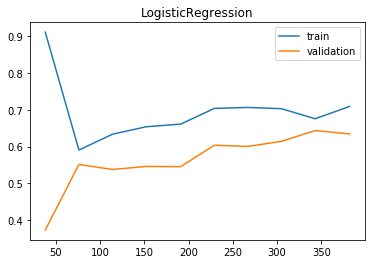

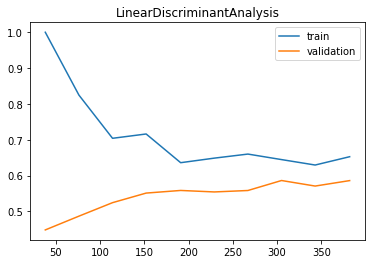

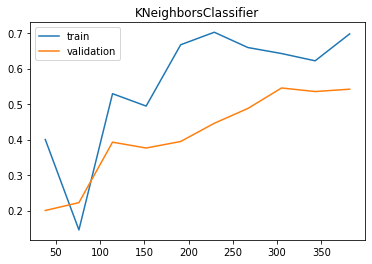

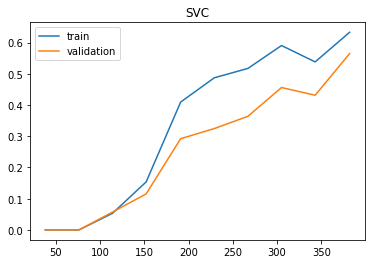

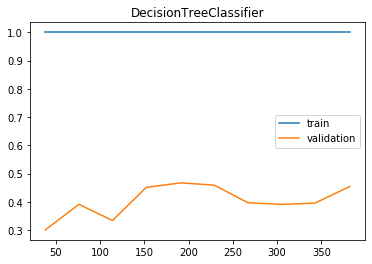

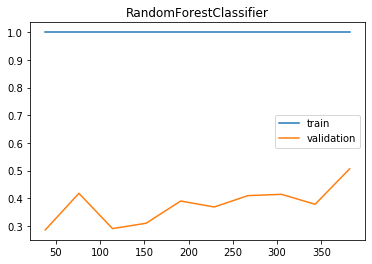

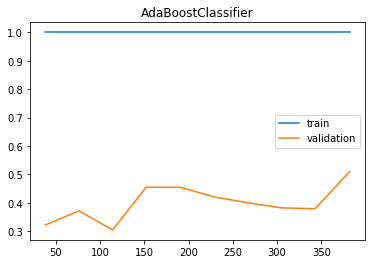

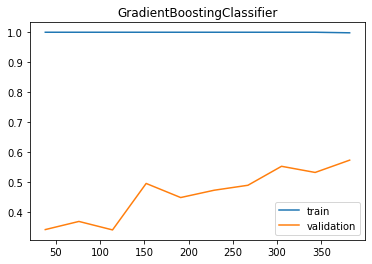

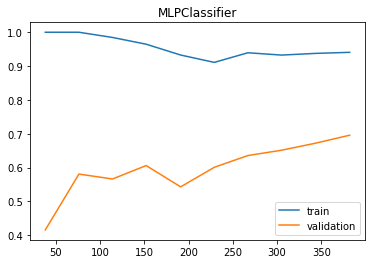

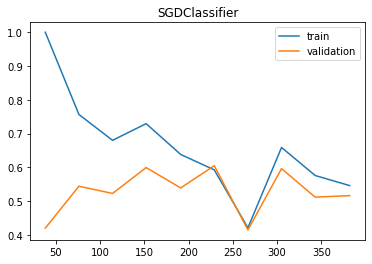

In [58]:
#Learning curve 
from sklearn.model_selection import learning_curve 

for cl in classifiers:
    N,train_score, val_score=learning_curve(cl, Xtransformed, y_transformed,train_sizes=np.linspace(0.1,1,10),scoring='f1',cv=cv)
    plt.figure()
    plt.plot(N,train_score.mean(axis=1),label='train')
    plt.plot(N,val_score.mean(axis=1),label='validation')
    plt.legend()
    plt.title(cl.__class__.__name__)

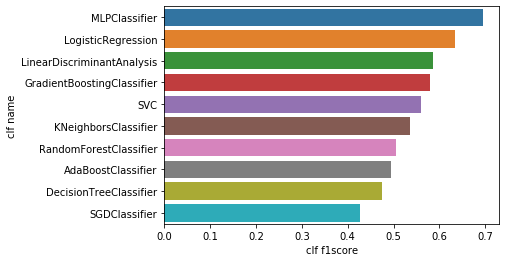

In [59]:
plt.figure()
sns.barplot(x=df_result['clf f1score'],y=df_result['clf name'],data=df_result)

In [67]:
#GridSearch Logitic Regression

param_grid={'penalty': ['l1','l2','elasticnet'],
            'C':[20,40,45,50,55,70],
           }

GridLR=GridSearchCV(LogisticRegression(), param_grid,cv=cv,scoring='f1')
GridLR.fit(Xtransformed, y_transformed)
print (GridLR.best_params_)
print (GridLR.best_score_)
LRBest=GridLR.best_estimator_


C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logisti

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selecti

{'C': 50, 'penalty': 'l2'}
0.6845849802371543


C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selecti

In [133]:
#GridSearch Logitic Regression avec feature engenieering
from sklearn.preprocessing import PolynomialFeatures
modelLR=make_pipeline(transformer,PolynomialFeatures(),LRBest)
param_grid={'polynomialfeatures__degree': [2,3]
           }

GridLR2=GridSearchCV(modelLR, param_grid,cv=cv,scoring='f1')
GridLR2.fit(X_train, y_transformed)
print (GridLR2.best_params_)
print (GridLR2.best_score_)
LRBest2=GridLR2.best_estimator_


C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

{'polynomialfeatures__degree': 3}
0.6094934787126111


C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

Text(0.5, 1.0, 'LogisticRegression')

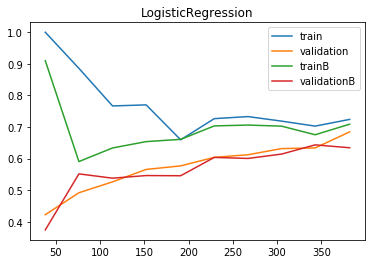

In [71]:
N,train_score, val_score=learning_curve(LRBest, Xtransformed, y_transformed,train_sizes=np.linspace(0.1,1,10),scoring='f1',cv=cv)
Nb,train_scoreb, val_scoreb=learning_curve(LogisticRegression(), Xtransformed, y_transformed,train_sizes=np.linspace(0.1,1,10),scoring='f1',cv=cv)

plt.figure()
plt.plot(N,train_score.mean(axis=1),label='train')
plt.plot(N,val_score.mean(axis=1),label='validation')
plt.plot(Nb,train_scoreb.mean(axis=1),label='trainB')
plt.plot(Nb,val_scoreb.mean(axis=1),label='validationB')
plt.legend()
plt.title(LRBest.__class__.__name__)

In [199]:
#GridSearch MLP


param_grid={'hidden_layer_sizes': [2,500],
            'learning_rate_init': [0.001,0.01],
            'activation':['logistic','tanh'],
            'learning_rate':['constant','adaptive'], 
           }
GridMLP=GridSearchCV(MLPClassifier(random_state=random_state), param_grid,cv=cv,scoring='f1')
GridMLP.fit(Xtransformed, y_transformed)
print (GridMLP.best_params_)
print (GridMLP.best_score_)
MLPBest=GridMLP.best_estimator_

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimi

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimi

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimi

{'activation': 'tanh', 'hidden_layer_sizes': 500, 'learning_rate': 'constant', 'learning_rate_init': 0.01}
0.7068571428571427


In [195]:
#GridSearch MLP with feature selection
#selector2=RFECV(SGDClassifier(),step=1 ,min_features_to_select=2,cv=5)

from sklearn.feature_selection import SelectFromModel

selector=SelectFromModel(SGDClassifier(random_state=1))

modelMLP=make_pipeline(transformer, selector, MLPBest)

param_grid={ 'selectfrommodel__threshold':['0.5*mean','mean','1.5*mean']           }

GridMLP2=GridSearchCV(modelMLP, param_grid,cv=cv,scoring='f1')
GridMLP2.fit(X_train, y_transformed)
print (GridMLP2.best_params_)
print (GridMLP2.best_score_)
MLPBest2=GridMLP2.best_estimator_

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimi

{'selectfrommodel__threshold': 'mean'}
0.6037402597402598


In [183]:
selector=SelectFromModel(SGDClassifier(random_state=1), threshold='mean')
selector.fit_transform(Xtransformed,y_transformed).shape



(478, 26)

In [184]:
Xtransformed.shape
selector.get_support()

array([False,  True,  True, False, False, False, False, False,  True,
        True,  True,  True,  True, False, False,  True,  True, False,
       False,  True,  True, False, False, False,  True,  True,  True,
       False,  True,  True, False, False, False, False, False, False,
       False,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True])

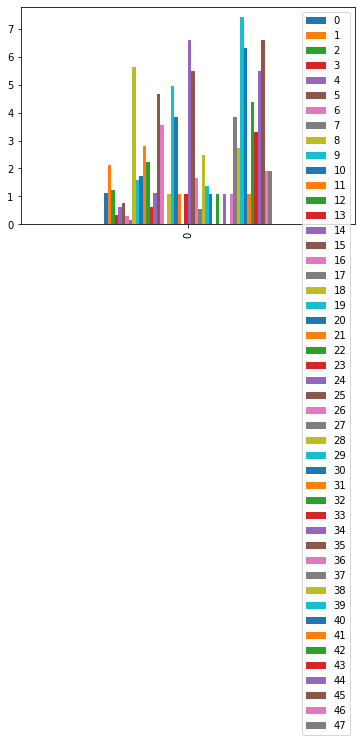

In [194]:
#
modelSGD=SGDClassifier(random_state=1)
modelSGD.fit(Xtransformed,y_transformed)
pd.DataFrame(np.abs(modelSGD.coef_)).plot.bar()


In [198]:
#GridSearch MLP with feature selection
#selector2=RFECV(SGDClassifier(),step=1 ,min_features_to_select=2,cv=5)

from sklearn.feature_selection import RFECV

selector3=RFECV(SGDClassifier(random_state=1),step=1,cv=5)
modelMLP=make_pipeline(transformer, selector3, MLPBest)

param_grid={ 'rfecv__min_features_to_select':[5,10,20,28,48]}

GridMLP3=GridSearchCV(modelMLP, param_grid,cv=cv,scoring='f1')
GridMLP3.fit(X_train, y_transformed)
print (GridMLP3.best_params_)
print (GridMLP3.best_score_)
MLPBest3=GridMLP3.best_estimator_

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimi

{'rfecv__min_features_to_select': 48}
0.7012019704433496


array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.01239474, 0.01239474, 0.00623676, 0.00623676, 0.04200294,
       0.04200294, 0.        , 0.02248297, 0.02248297, 0.14211936,
       0.14211936, 0.00829817, 0.00829817, 0.00416659, 0.00416659,
       0.        , 0.00208767, 0.00208767, 0.00208767, 0.00208767,
       0.00416659, 0.00416659, 0.00416659, 0.00416659, 0.03623886,
       0.03623886, 0.        , 0.00829817, 0.00829817, 0.04580189,
       0.16174874, 0.08357697, 0.0588225 ])

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimi

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimi

Text(0.5, 1.0, 'MLPClassifier')

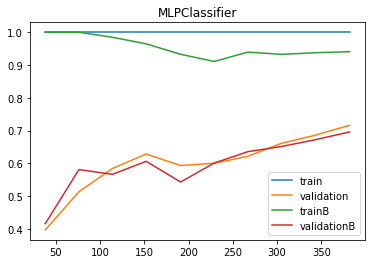

In [75]:
#Learning Curve MLP
N,train_score, val_score=learning_curve(MLPBest, Xtransformed, y_transformed,train_sizes=np.linspace(0.1,1,10),scoring='f1',cv=cv)
Nb,train_scoreb, val_scoreb=learning_curve(MLPClassifier(random_state=random_state), Xtransformed, y_transformed,train_sizes=np.linspace(0.1,1,10),scoring='f1',cv=cv)

plt.figure()
plt.plot(N,train_score.mean(axis=1),label='train')
plt.plot(N,val_score.mean(axis=1),label='validation')
plt.plot(Nb,train_scoreb.mean(axis=1),label='trainB')
plt.plot(Nb,val_scoreb.mean(axis=1),label='validationB')
plt.legend()
plt.title(MLPBest.__class__.__name__)

In [76]:
# GridSearchCV Gradient Boosting Classifier
params={'n_estimators':[20,50,100,300],
        'subsample':np.linspace(0,1,2),
        'learning_rate':[0.1,0.3,0.9],
        'loss':['exponential','deviance'],
        'criterion':['friedman_mse','mse','mae'],
        'max_features':['auto', 'sqrt', 'rbf', 'log2'], 
       }
        
GridGB=GridSearchCV(GradientBoostingClassifier(random_state=random_state), param_grid=params,cv=cv,scoring='f1')
GridGB.fit(Xtransformed, y_transformed)
print (GridGB.best_params_)
print (GridGB.best_score_)
GBBest=GridGB.best_estimator_

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: subsample must be in (0,1] but was 0.0

  FitFailedWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\

{'criterion': 'friedman_mse', 'learning_rate': 0.3, 'loss': 'deviance', 'max_features': 'log2', 'n_estimators': 50, 'subsample': 1.0}
0.6592475479432001


Text(0.5, 1.0, 'GradientBoostingClassifier')

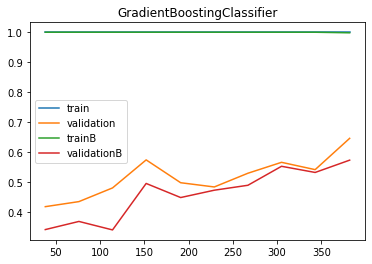

In [77]:
#Learning Curve Gradient Boosting Classifier
N,train_score, val_score=learning_curve(GBBest, Xtransformed, y_transformed,train_sizes=np.linspace(0.1,1,10),scoring='f1',cv=cv)
Nb,train_scoreb, val_scoreb=learning_curve(GradientBoostingClassifier(random_state=random_state), Xtransformed, y_transformed,train_sizes=np.linspace(0.1,1,10),scoring='f1',cv=cv)

plt.figure()
plt.plot(N,train_score.mean(axis=1),label='train')
plt.plot(N,val_score.mean(axis=1),label='validation')
plt.plot(Nb,train_scoreb.mean(axis=1),label='trainB')
plt.plot(Nb,val_scoreb.mean(axis=1),label='validationB')
plt.legend()
plt.title(GBBest.__class__.__name__)

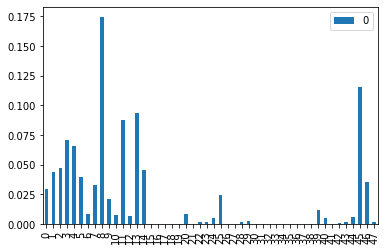

In [95]:
pd.DataFrame(GBBest.feature_importances_,index=np.arange(Xtransformed.shape[1])).plot.bar()
#Xtransformed.shape

In [204]:
#Ensemble learning (Voting/ boosting/bagging)
from sklearn.ensemble import VotingClassifier, BaggingClassifier
VotingC=VotingClassifier([('MLP',MLPBest),('LR',LRBest)],voting='soft')
cross_val_score(VotingC,Xtransformed, y_transformed, scoring='f1', cv=cv).mean()


0.7068571428571427

In [207]:
#bagging

classifiers1 = [
              LogisticRegression(random_state = random_state),
              LRBest,
              LinearDiscriminantAnalysis(),
              KNeighborsClassifier(),
              SVC(random_state=random_state),
              DecisionTreeClassifier(random_state=random_state),
              RandomForestClassifier(random_state=random_state),
              AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1),
              GradientBoostingClassifier(random_state=random_state),
              MLPClassifier(random_state=random_state),
              MLPBest,
              SGDClassifier(random_state = random_state)
              ]
for cl in classifiers1:
    BC=BaggingClassifier(base_estimator=cl,n_estimators=100)
    score=cross_val_score(BC,Xtransformed, y_transformed, scoring='f1', cv=cv).mean()
    print(f'le score du model {cl.__class__.__name__ :.<50} avec Bagging est {score}')

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

le score du model LogisticRegression................................ avec Bagging est 0.6342857142857143


C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

le score du model LogisticRegression................................ avec Bagging est 0.6628926006205109
le score du model LinearDiscriminantAnalysis........................ avec Bagging est 0.583785055524186
le score du model KNeighborsClassifier.............................. avec Bagging est 0.5663703703703705
le score du model SVC............................................... avec Bagging est 0.5540009443899603
le score du model DecisionTreeClassifier............................ avec Bagging est 0.5087819548872181
le score du model RandomForestClassifier............................ avec Bagging est 0.4366357069143446
le score du model AdaBoostClassifier................................ avec Bagging est 0.5191377318333841
le score du model GradientBoostingClassifier........................ avec Bagging est 0.5885714285714286


C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimi

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimi

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimi

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimi

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimi

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimi

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimi

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimi

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimi

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimi

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimi

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimi

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimi

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimi

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimi

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimi

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimi

le score du model MLPClassifier..................................... avec Bagging est 0.6399820868786386
le score du model MLPClassifier..................................... avec Bagging est 0.6821407867494823
le score du model SGDClassifier..................................... avec Bagging est 0.6737624694146434


In [225]:
best = [LRBest,MLPBest,GBBest]
             
for cl in best :
    print(f'le score sur le test set du best modèle {cl.__class__.__name__} est ')
    print(classification_report(ytesttransformed,cl.predict(Xtesttransformed)))


le score sur le test set du best modèle LogisticRegression est 
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       107
           1       0.62      0.62      0.62        13

    accuracy                           0.92       120
   macro avg       0.78      0.78      0.78       120
weighted avg       0.92      0.92      0.92       120

le score sur le test set du best modèle MLPClassifier est 
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       107
           1       0.40      0.31      0.35        13

    accuracy                           0.88       120
   macro avg       0.66      0.63      0.64       120
weighted avg       0.86      0.88      0.87       120

le score sur le test set du best modèle GradientBoostingClassifier est 
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       107
           1       0.60      0.46      0.5

In [245]:
from sklearn.metrics import recall_score
best1 = [      LogisticRegression(random_state = random_state),
              LinearDiscriminantAnalysis(),
              KNeighborsClassifier(),
              SVC(random_state=random_state),
              DecisionTreeClassifier(random_state=random_state),
              RandomForestClassifier(random_state=random_state),
              AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1),
              GradientBoostingClassifier(random_state=random_state),
              MLPClassifier(random_state=random_state),
              SGDClassifier(random_state = random_state)
       ]
for cl in best1 :
    cl.fit(Xtransformed,y_transformed)
    print(f'le score sur le test set du  modèle {cl.__class__.__name__  :.<50} {recall_score(ytesttransformed,cl.predict(Xtesttransformed))}')
    #print(classification_report(ytesttransformed,cl.predict(Xtesttransformed)))


le score sur le test set du  modèle LogisticRegression................................ 0.6153846153846154
le score sur le test set du  modèle LinearDiscriminantAnalysis........................ 0.5384615384615384
le score sur le test set du  modèle KNeighborsClassifier.............................. 0.38461538461538464
le score sur le test set du  modèle SVC............................................... 0.3076923076923077
le score sur le test set du  modèle DecisionTreeClassifier............................ 0.5384615384615384
le score sur le test set du  modèle RandomForestClassifier............................ 0.3076923076923077
le score sur le test set du  modèle AdaBoostClassifier................................ 0.46153846153846156
le score sur le test set du  modèle GradientBoostingClassifier........................ 0.46153846153846156
le score sur le test set du  modèle MLPClassifier..................................... 0.38461538461538464
le score sur le test set du  modèle SGDCla

C:\Users\p084466\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
